<a href="https://colab.research.google.com/github/OlyaSto/Olyabmstu/blob/master/%D0%A2%D0%9C%D0%9E/%D0%9B%D0%A06/LR6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Лабораторная работа №6

Цель лабораторной работы: изучение основных методов анализа и прогнозирование временных рядов.

Задание:
1. Выберите набор данных (датасет) для решения задачи прогнозирования временного ряда.
2. Визуализируйте временной ряд и его основные характеристики.
3. Разделите временной ряд на обучающую и тестовую выборку.
4. Произведите прогнозирование временного ряда с использованием как минимум двух методов.
5. Визуализируйте тестовую выборку и каждый из прогнозов.
6. Оцените качество прогноза в каждом случае с помощью метрик.

## Импорт библиотек

In [116]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Загрузка данных

Монтирование Google Drive для получения доступа к данным, лежащим на нем:

In [130]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузка данных:

In [131]:
filename = '/content/drive/MyDrive/POP.csv'

In [132]:
data = pd.read_csv(filename, sep=',')

In [133]:
data = data.drop(['realtime_start','realtime_end'],axis=1)
"""Преобразование столбца даты в объект datetime и установка его в качестве индекса"""
data['date'] = pd.to_datetime(data['date'])
data.set_index('date',inplace=True)
data.head()

,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0


In [134]:

data.describe()

,value
count,816.000000
mean,243847.767826
std,50519.140567
min,156309.000000
25%,201725.250000
50%,239557.500000
75%,289364.250000
max,330309.946000


В качестве датасета будем использовать набор данных, содержащий данные для прогнозирования цен на акции компании Netflix.
https://www.kaggle.com/datasets/ranugadisansagamage/netflix-stocks

Датасет содержит следующие атрибуты:
1. Date - The day - Дата
2. Open - The open Price of the Stock - цена в день открытия акции
3. High - The highest price of the stock - самая высокая цена акции
4. Low - The lowest price of the stock - самая низкая цена акции
5. Close - The closing price of the stock - цена акции в день закрытия
6. Adj Close - amends a stock's closing price to reflect that stock's value after accounting for any corporate actions - изменяет цену закрытия акции, чтобы отразить стоимость этой акции после учета любых корпоративных действий
7. Value - объем продаж

## Визуализация временного ряда

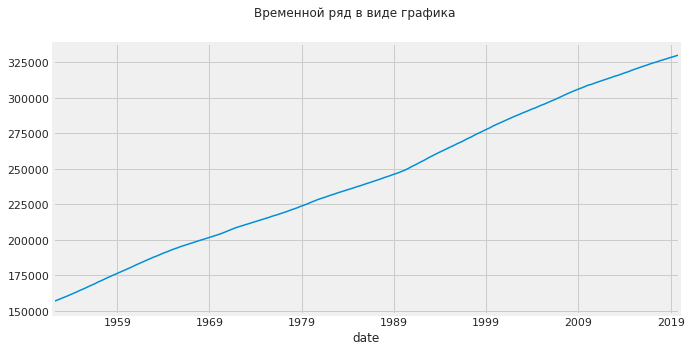

In [135]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде графика')
data.plot(ax=ax, legend=False)
pyplot.show()

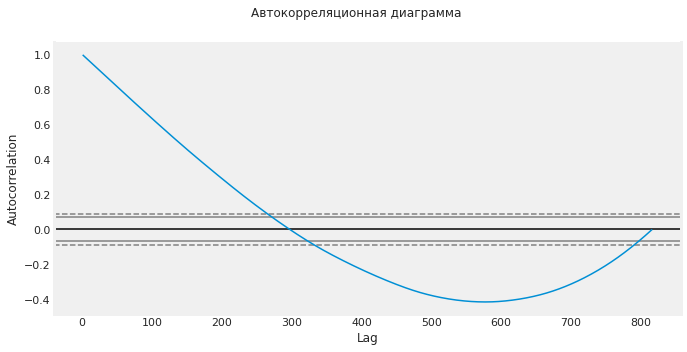

In [136]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Автокорреляционная диаграмма')
pd.plotting.autocorrelation_plot(data, ax=ax)
pyplot.show()

### Частичная автокорреляционная функция

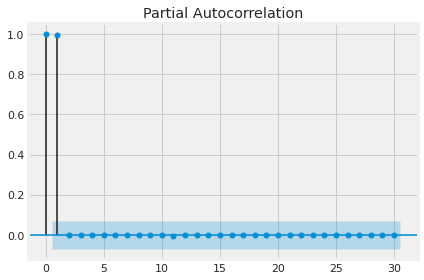

In [137]:
plot_pacf(data, lags=30)
plt.tight_layout()

## Разделение временного ряда на обучающую и тестовую выборку

In [138]:
data2 = data.copy()

In [139]:
# Целочисленная метка шкалы времени 
xnum = list(range(data2.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = data2['value'].values
train_size = int(len(Y) * 0.7)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]
history_es = [x for x in train]

## Прогнозирование временного ряда авторегрессионным методом (ARIMA)

In [160]:
from statsmodels.tsa.arima_model import ARIMA

In [141]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [151]:
from sklearn.metrics import mean_squared_error

In [152]:
# Параметры модели (p,d,q) 
arima_order = (2,1,0)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])
# Вычисление метрики RMSE
error_arima = mean_squared_error(test, predictions_arima, squared=False)

In [153]:
# Ошибка прогноза
np.mean(Y), error_arima

(243847.7678259804, 7372.900036604332)

In [161]:
# Формирование предсказаний
predictions_es = list()
for t in range(len(test)):
    model_es = ExponentialSmoothing(history_es)
    model_es_fit = model_es.fit()
    yhat_es = model_es_fit.forecast()[0]
    predictions_es.append(yhat_es)
    history_es.append(test[t])
# Вычисление метрики RMSE
error_es = mean_squared_error(test, predictions_es, squared=False)

In [171]:
# Записываем предсказания в DataFrame
data2['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)
data2['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_es)

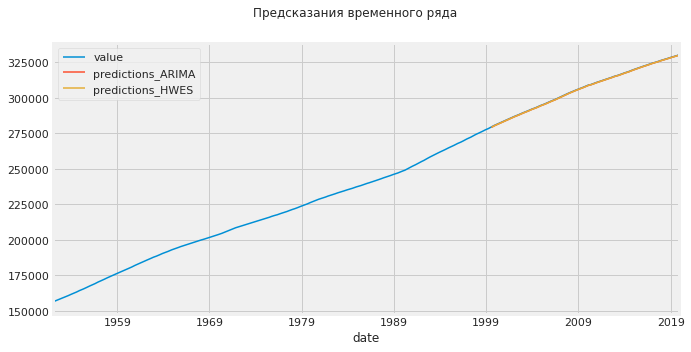

In [172]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
data2.plot(ax=ax, legend=True)
pyplot.show()

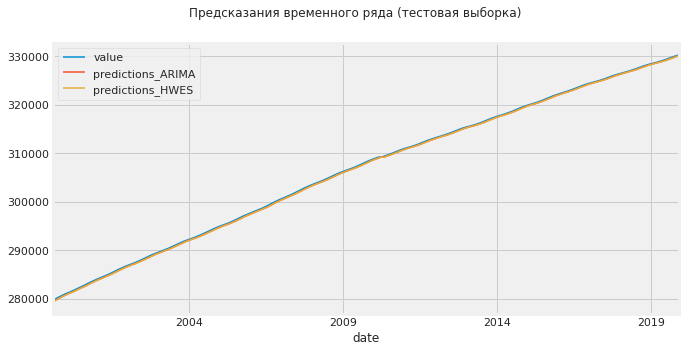

In [173]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data2[train_size:].plot(ax=ax, legend=True)
pyplot.show()

## Прогнозирование временного ряда методом символьной регресии

In [167]:
pip install gplearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [169]:
from gplearn.genetic import SymbolicRegressor

In [170]:
function_set = ['add', 'sub', 'mul', 'div', 'sin']
SR = SymbolicRegressor(population_size=500, metric='mse',
                               generations=70, stopping_criteria=0.01,
                               init_depth=(4, 10), verbose=1, function_set=function_set,
                               const_range=(-100, 100), random_state=0)

In [174]:
SR.fit(np.array(xnum_train).reshape(-1, 1), train.reshape(-1, 1))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   263.65      2.43463e+63       23      7.14077e+09              N/A      2.97m
   1   130.98      5.77055e+16       43      6.06688e+09              N/A      1.21m
   2    53.10      4.58992e+15       34      3.54847e+09              N/A     44.30s
   3    34.28      1.99853e+19       13      1.42699e+09              N/A     34.84s
   4    35.05      2.10424e+16       38      1.04052e+09              N/A     35.31s
   5    30.47      2.56729e+16       36      4.29436e+08              N/A     32.71s
   6    31.30      3.00498e+16       50      6.39791e+07              N/A     32.03s
   7    38.37      8.59782e+15       35      1.51165e+07              N/A     33.31s
   8    43.37      5.29474e+15       47      4.76034e+06              N/A  

SymbolicRegressor(const_range=(-100, 100),
                  function_set=['add', 'sub', 'mul', 'div', 'sin'],
                  generations=70, init_depth=(4, 10), metric='mse',
                  population_size=500, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [177]:
# Предсказания
y_sr = SR.predict(np.array(xnum_test).reshape(-1, 1))
y_sr[:10]

array([274891.75793852, 274817.36307349, 275068.42349884, 275594.91553188,
       275909.57465535, 276033.9204471 , 276192.3291504 , 276368.95663777,
       276651.56236873, 276542.01774132])

## Качество прогноза моделей

In [175]:
def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred, squared=False)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

In [180]:
print("ARIMA")
print_metrics(test, predictions_arima)

print("\nGPLEARN")
print_metrics(test, y_sr)

ARIMA
R^2: 0.7495397912366841
MSE: 7372.900036604332
MAE: 751.3845663510563

GPLEARN
R^2: 0.8047153645391025
MSE: 6510.330169456957
MAE: 6443.710113418146
